# UMAP Plot

Use the bodies of text generated by the feature extraction script to create a UMAP Plot.

## Load Features

Load all information for all feeds in the database that have features.

Store the results in the *feeds* dict.

In [2]:
import sqlite3
import umap, umap.plot
from sklearn.feature_extraction.text import CountVectorizer
from corextopic import corextopic as ct
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# stores all information about a feed
feeds = dict()

print('Loading features...')

# connect to the db
conn = sqlite3.connect('feeds_dev.db')
c = conn.cursor()
    
# select only the feeds for which the body of text 
# has already been generated
c.execute('SELECT url, text, title, description FROM feeds WHERE text IS NOT NULL AND title IS NOT NULL AND description IS NOT NULL;')
for entry in c.fetchall():

    feeds[entry[0]] = {
        'features': entry[1],
        'title': entry[2],
        'description': entry[3]
    }        

print('Loaded features for ' + str(len(feeds)) + ' feeds')

Loading features...
Loaded features for 4980 feeds


## Vectorize Documents

Create a doc-word matrix based on the data in the *feeds* dict. 

Each row in the matrix corresponds to a feed and each column corresponds to a word.

In [3]:
corpus = list(v['features'] for v in feeds.values())
vectorizer = CountVectorizer(max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(corpus)

# get the words (column labels)
words = vectorizer.get_feature_names()

# get the docs/feeds (keys of the feeds dict)
docs = list(feeds.keys())

print('Shape of doc-word matrix: ', str(doc_word.shape))
print('Number of documents (feeds): ', str(len(docs)))
print('Number of words (features): ', str(len(words)))

Shape of doc-word matrix:  (4980, 20000)
Number of documents (feeds):  4980
Number of words (features):  20000


## CorEx Topic Modelling

Use the CorEx library to infert topics from the bodies of text of the feeds.

### Train the Model

In [4]:
# train the CorEx topic model
topic_model = ct.Corex(n_hidden=10, words=words, docs=docs, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words, docs=docs)

### Plot the Distribution of TCs For Each Topic

Use the plot to select an appropriate number of topics. Keep adding topics until additional ones do not significantly contribute to the overall TC.

Text(0, 0.5, 'Total Correlation (nats)')

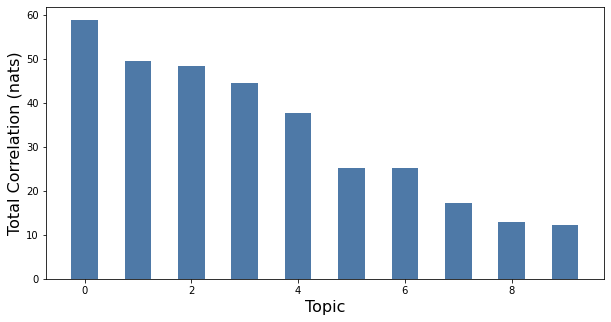

In [5]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)

### Display All Topics Generated

In [6]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: possible, others, include, become, pay, work, within, matter, working, example
1: later, came, could, end, left, took, point, found, next, able
2: four, due, group, return, five, third, young, despite, public, says
3: enough, side, give, makes, instead, least, used, keep, another, see
4: white, red, large, half, light, green, using, water, dry, main
5: dish, sauce, delicious, recipe, chicken, ingredients, sweet, rice, recipes, cheese
6: space, heart, area, walk, view, blue, beautiful, family, visit, evening
7: government, war, rights, police, law, president, legal, death, minister, political
8: pop, brand, music, stage, video, collection, series, king, tv, scene
9: wear, wearing, dress, jeans, fashion, jacket, shoes, shirt, bag, worn


### Assign a Topic to Each Feed

For each feed, assign it the topic such that the feed has the highest probability of belonging to that topic.

In [7]:
# Make a hard assignment of one topic per document
hard_labels = np.zeros(doc_word.shape[0])

for i in range(hard_labels.shape[0]):
    hard_labels[i] = np.argmax(topic_model.p_y_given_x[i])

## Generate UMAP Plot

Create an interactive UMAP plot based on the probabilities that each feed belongs to a topic. 

Use the hard assignments computed before as the labels for the feeds.

Loading BokehJS ...

<AxesSubplot:>

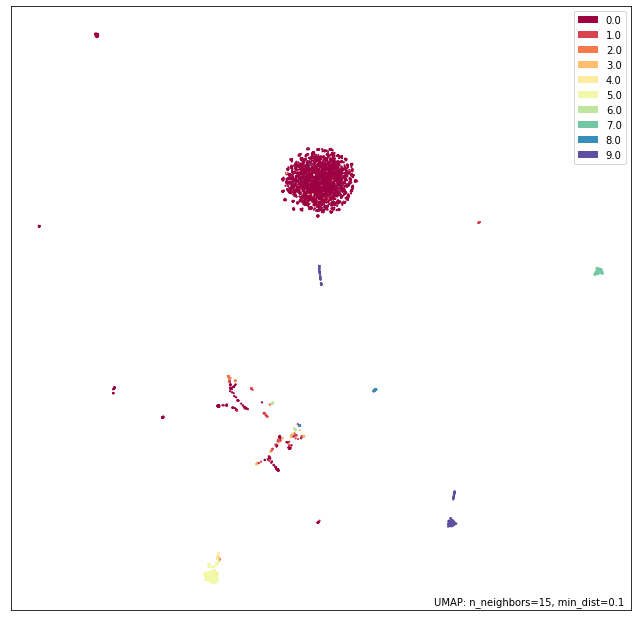

In [8]:
# fit UMAP model
mapper = umap.UMAP().fit(topic_model.p_y_given_x)

# data to be displayed when hovering over a point in the interactive plot
hover_data = pd.DataFrame({
    'title': [v['title'] for v in feeds.values()],
    'description': [v['description'] for v in feeds.values()]
})

umap.plot.output_notebook()
p = umap.plot.interactive(mapper, labels=hard_labels, hover_data=hover_data, point_size=2)
umap.plot.show(p)

umap.plot.points(mapper, hard_labels)